<a href="https://colab.research.google.com/github/opensites/colab-notebooks-public/blob/main/models/gen-text-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# Import Tensorflow 2.0
import enum
import tensorflow as tf
from tensorflow.keras import layers
import math

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

import pandas as pd

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) >= 0

Now we can upload the data files from our computer (access using the [tutorial linked here](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92))

In [39]:
from google.colab import files
uploaded = files.upload()

Saving train-prompt2.csv to train-prompt2 (2).csv


In [40]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
# load the dataset
import io
df_prompt2 = pd.read_csv(io.BytesIO(uploaded['train-prompt2.csv']))
df_prompt2["Prompt"] = "promptstartseq " + df_prompt2["Prompt"] + " promptendseq"
df_prompt2["Response"] = "responsestartseq " + df_prompt2["Response"] + " responseendseq"
df_prompt_2_all_text = ""
for entry in df_prompt2.values:
  df_prompt_2_all_text = df_prompt_2_all_text + f'{entry[0]} {entry[1]} '

print(df_prompt_2_all_text)

promptstartseq Look at the little cat go! promptendseq responsestartseq The frog is by the cat on the log. responseendseq promptstartseq My big dog can see the rat in the fog! promptendseq responsestartseq The cat may play with the rat day. responseendseq promptstartseq I said, 'the cat is on the mat!' promptendseq responsestartseq The mat is by the cat. responseendseq promptstartseq We can see the sun up in the sky. promptendseq responsestartseq The sun is up. responseendseq promptstartseq I will stay here all day. promptendseq responsestartseq It is sunny today. responseendseq promptstartseq This hat is for you. promptendseq responsestartseq Thank you. responseendseq promptstartseq One day I will be a big frog! promptendseq responsestartseq You will grow larger. responseendseq promptstartseq This key is for the door. promptendseq responsestartseq The door is open. responseendseq promptstartseq I like to run and play. promptendseq responsestartseq That is fun. responseendseq promptsta

In [42]:
# Make a text-only dataset (without labels), then call adapt
all_data_tensor = tf.constant(df_prompt2.astype(str).values)
condensed_data_tensor = tf.reshape(all_data_tensor,[-1])

# number of unique words in the dataset after punctuation filtering
word_count_layer = layers.TextVectorization()
word_count_layer.adapt(condensed_data_tensor)
num_words = len(word_count_layer.get_vocabulary())
print(f'There are {num_words} unique words in this dataset')
print(word_count_layer.get_vocabulary()[0:10])

There are 738 unique words in this dataset
['', '[UNK]', 'the', 'promptstartseq', 'promptendseq', 'responsestartseq', 'responseendseq', 'is', 'i', 'a']


In [63]:
# tokenizer
# https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
# https://www.tensorflow.org/tutorials/keras/text_classification
max_features = math.floor(num_words * 1.5)
sequence_length = 100

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    ngrams=1,
    output_sequence_length=None)

# build vocab for this dataset
vectorize_layer.adapt(condensed_data_tensor)

# save the vocabulary as a standard python list
vocab = vectorize_layer.get_vocabulary()

# how far did ngram truly go
max_ngram_size = 0
for item in vocab:
    max_ngram_size = max(max_ngram_size, len(item.split()))


print(f'The maximum ngram found was {max_ngram_size}.')

# # see some vocab details
print(" 10 ---> ", vocab[10])
print(" 50 ---> ", vocab[50])
print(" -1 ---> ", vocab[-1])
print(f'Vocabulary size: {len(vocab)}')
print('promptstartseq' in vocab)
print('promptendseq' in vocab)

The maximum ngram found was 1.
 10 --->  to
 50 --->  said
 -1 --->  abdominal
Vocabulary size: 738
True
True


In [64]:

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.1, test_split=0.1):

    total_split = train_split + test_split + val_split
    if total_split != 1:
      train_split = train_split / total_split
      test_split = test_split / total_split
      val_split = val_split / total_split

    # Specify seed to always have the same split distribution between runs
    df_shuffled = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(train_split * len(df)), int((train_split + val_split) * len(df))]
    
    train_ds, val_ds, test_ds = np.split(df_shuffled, indices_or_sections)
    
    return train_ds, val_ds, test_ds

In [65]:
# see article here: https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
# and docs here: https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = ds.cardinality().numpy()
    total_split = train_split + test_split + val_split
    if total_split != 1:
      train_split = train_split / total_split
      test_split = test_split / total_split
      val_split = val_split / total_split

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=2011)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [66]:
ds_all = tf.data.Dataset.from_tensor_slices(all_data_tensor)
train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds_all)

In [67]:
train_ds_pd, val_ds_pd, test_ds_pd = get_dataset_partitions_pd(df_prompt2)
train_ds_tensor = tf.constant(train_ds_pd.astype(str).values)
val_ds_tensor = tf.constant(val_ds_pd.astype(str).values)
test_ds_tensor = tf.constant(test_ds_pd.astype(str).values)

# vectorize the input and target
vector_prompts = vectorize_layer(train_ds_tensor[:,0])
vector_responses = vectorize_layer(train_ds_tensor[:,1])

print(train_ds_tensor[4,1])
print(vector_prompts[0])
print(vector_responses[4])
print(vector_responses.shape[1])

vocab[3]

tf.Tensor(b"responsestartseq Who doesn't? responseendseq", shape=(), dtype=string)
tf.Tensor([ 3 53  7 19  9 43  4  0  0  0  0  0  0  0  0], shape=(15,), dtype=int64)
tf.Tensor(
[  5  87 101   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(31,), dtype=int64)
31


'promptstartseq'

In [72]:
### Batch definition to create training examples ###

def get_batch(tokenized_all_text, batch_size, sequence_length):

    # number of words
    n = len(tokenized_all_text)

    # randomly choose the starting indices for the examples in the training batch
    sample_indices = np.random.choice(n - sequence_length, batch_size) 

    # build the batch
    context_batch = tf.constant([tokenized_all_text.numpy()[index:index + sequence_length] for index in sample_indices])
    target_batch = tf.constant([tokenized_all_text.numpy()[index + 1:index + sequence_length + 1] for index in sample_indices])

    return context_batch, target_batch

tokenized_all_text = vectorize_layer(df_prompt_2_all_text)
c, t = get_batch(tokenized_all_text, 2, 10)

print(tokenized_all_text.shape)
print(c)
print(t)



(12284,)
tf.Tensor(
[[112   6   3   7   2 142 156 126 102   4]
 [ 66  89 236  29   6   3  33   2 114  88]], shape=(2, 10), dtype=int32)
tf.Tensor(
[[  6   3   7   2 142 156 126 102   4   5]
 [ 89 236  29   6   3  33   2 114  88  95]], shape=(2, 10), dtype=int32)


In [77]:

def LSTM(rnn_units, stateful=True):
    return tf.keras.layers.LSTM(
        rnn_units,
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        recurrent_activation='sigmoid',
        stateful=stateful,
    )

### Defining the RNN Model ###


def build_model(vocab_size, embedding_dim, rnn_units, batch_size):

    first_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True) if batch_size is None else tf.keras.layers.Embedding(
        vocab_size, embedding_dim, batch_input_shape=[batch_size, None], mask_zero=True)

    LSTM_layer = LSTM(rnn_units, stateful=False) if batch_size is None else LSTM(rnn_units)

    model = tf.keras.Sequential([

        # Layer 0: mask zeros in time steps, i.e., data does not exist
        # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Masking
        # https://www.tensorflow.org/guide/keras/masking_and_padding
        # tf.keras.layers.Masking(mask_value=0.0),

        # Layer 1: Embedding layer to transform indices into dense vectors
        #   of a fixed embedding size
        # mask zeros for diff length inputs
        first_layer,

        # dropout to prevent overfitting
        tf.keras.layers.Dropout(.2),

        # Layer 2: LSTM with `rnn_units` number of units.
        LSTM_layer,

        # dropout to prevent overfitting
        tf.keras.layers.Dropout(.2),

        # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
        #   into the vocabulary size. NOTE: output will need to have softmax applied...no activation
        tf.keras.layers.Dense(vocab_size)
    ])

    return model

# loss function, negative log likelihood


def compute_loss(labels, logits):
    # from_logits means we compare against the output probability distribution
    loss = tf.keras.losses.sparse_categorical_crossentropy(
        labels, logits, from_logits=True)
    return loss


#################################################################
### Hyperparameter setting and optimization ###
# Optimization parameters:
num_training_iterations = 20001  # Increase this to train longer
batch_size = 64  # Experiment between 1 and 64
initial_learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters:
embedding_dim = 256
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location:
checkpoint_dir = '/content/gdrive/MyDrive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

### Define optimizer and training operation ###
# Build a simple model with above hyperparameters.
model = build_model(vocab_size=len(vocab),
                    embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=batch_size)

# learning rate schedule
# see here:https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=7500,
    decay_rate=0.1,
    staircase=True)


# specific gradient descent algorithm choice.
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
)


@tf.function
def train_step(x, y):
    # Use tf.GradientTape()
    with tf.GradientTape() as tape:

        # generate predictions. Use training=True since we have dropout (acts differently in tng vs inference,
        # see here: https://www.tensorflow.org/tutorials/quickstart/advanced)
        y_hat = model(x, training=True)

        loss = compute_loss(y, y_hat)

        # Compute the gradients
        # We want the gradient of the loss with respect to all of the model parameters.
        # Use `model.trainable_variables` to get a list of all model parameters.
        grads = tape.gradient(loss, model.trainable_variables)

        # Apply the gradients to the optimizer so it can update the model accordingly
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

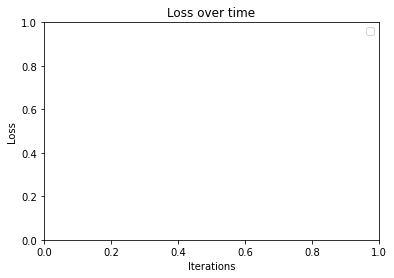

  0%|          | 0/20001 [00:00<?, ?it/s]

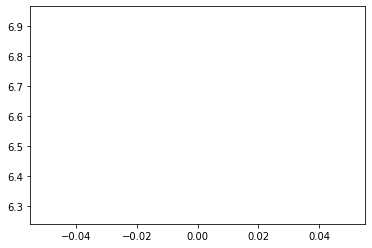

  0%|          | 100/20001 [00:16<25:23, 13.06it/s]

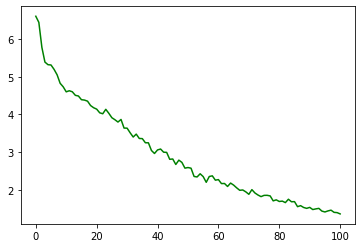

  1%|          | 200/20001 [00:24<25:42, 12.84it/s]

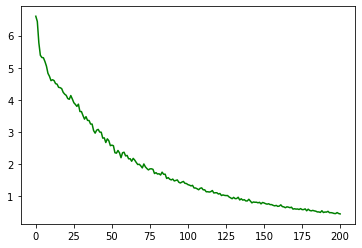

  1%|▏         | 300/20001 [00:32<26:20, 12.47it/s]

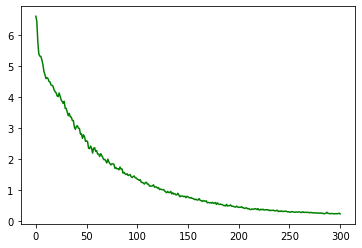

  2%|▏         | 400/20001 [00:41<26:26, 12.36it/s]

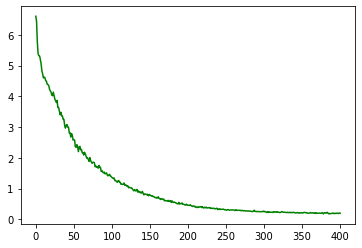

  2%|▏         | 500/20001 [00:49<26:18, 12.35it/s]

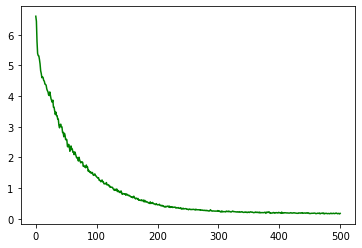

  3%|▎         | 600/20001 [00:57<25:41, 12.59it/s]

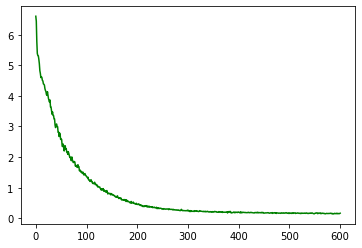

  3%|▎         | 700/20001 [01:05<24:57, 12.89it/s]

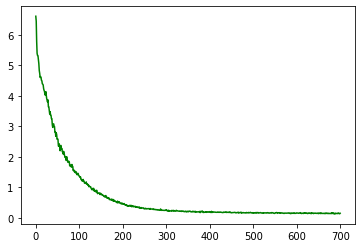

  4%|▍         | 800/20001 [01:13<24:36, 13.00it/s]

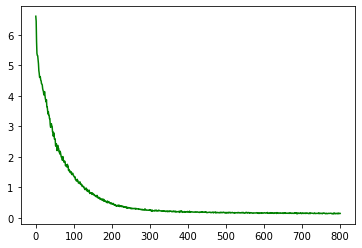

  4%|▍         | 900/20001 [01:21<24:24, 13.05it/s]

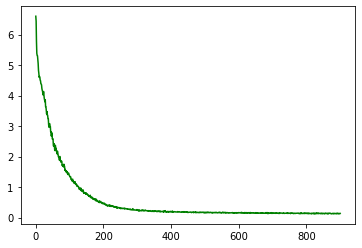

  5%|▍         | 1000/20001 [01:29<24:16, 13.05it/s]

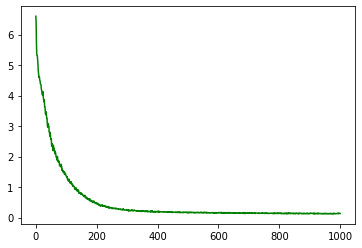

  5%|▌         | 1100/20001 [01:37<24:04, 13.09it/s]

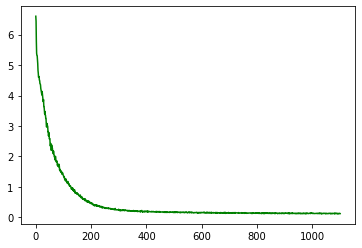

  6%|▌         | 1200/20001 [01:45<23:58, 13.07it/s]

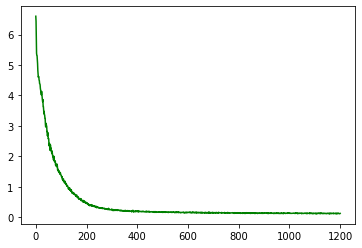

  6%|▋         | 1300/20001 [01:53<24:08, 12.91it/s]

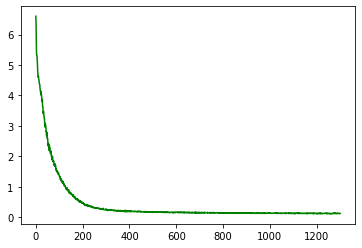

  7%|▋         | 1400/20001 [02:01<24:01, 12.90it/s]

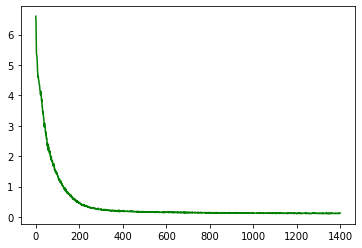

  7%|▋         | 1500/20001 [02:09<23:59, 12.86it/s]

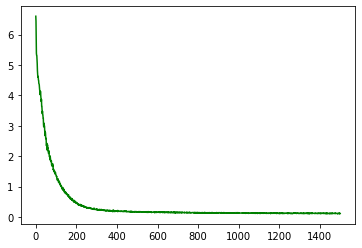

  8%|▊         | 1600/20001 [02:17<24:00, 12.77it/s]

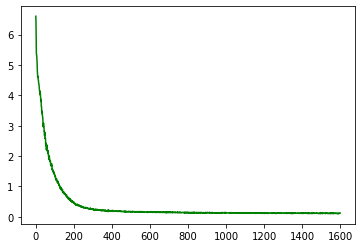

  8%|▊         | 1700/20001 [02:25<23:54, 12.76it/s]

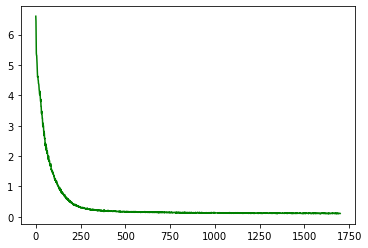

  9%|▉         | 1800/20001 [02:33<23:36, 12.85it/s]

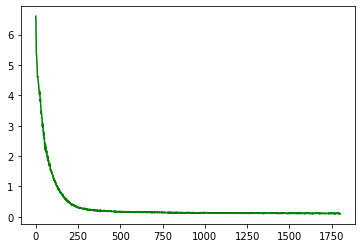

  9%|▉         | 1900/20001 [02:41<23:30, 12.83it/s]

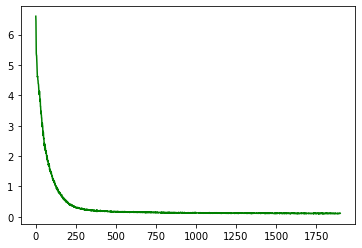

 10%|▉         | 2000/20001 [02:49<23:17, 12.88it/s]

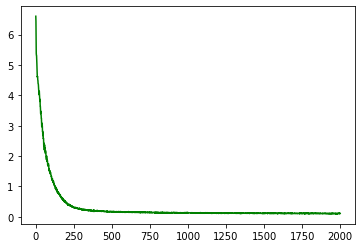

 10%|█         | 2100/20001 [02:57<23:03, 12.94it/s]

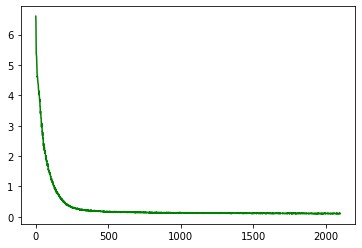

 11%|█         | 2200/20001 [03:05<22:53, 12.96it/s]

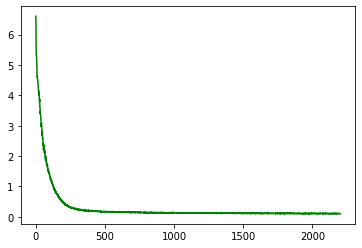

 11%|█▏        | 2300/20001 [03:13<22:35, 13.06it/s]

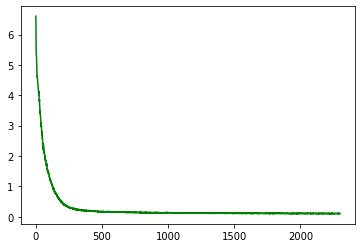

 12%|█▏        | 2400/20001 [03:21<22:55, 12.79it/s]

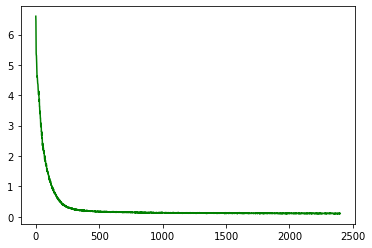

 12%|█▏        | 2500/20001 [03:29<22:38, 12.88it/s]

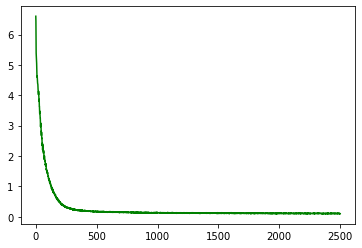

 13%|█▎        | 2600/20001 [03:37<22:43, 12.76it/s]

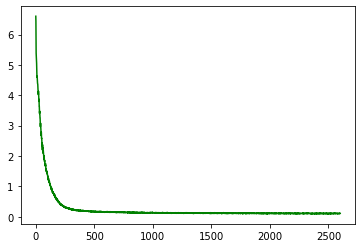

 13%|█▎        | 2700/20001 [03:45<22:23, 12.88it/s]

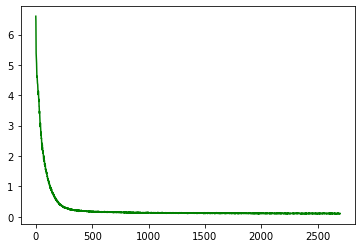

 14%|█▍        | 2800/20001 [03:53<22:26, 12.77it/s]

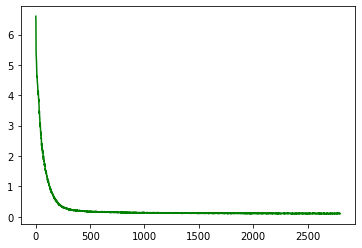

 14%|█▍        | 2900/20001 [04:01<22:11, 12.84it/s]

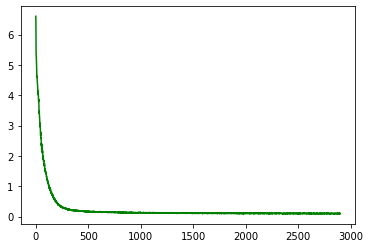

 15%|█▍        | 3000/20001 [04:09<22:08, 12.80it/s]

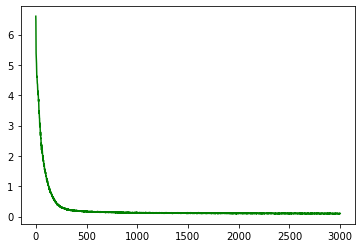

 15%|█▌        | 3100/20001 [04:17<21:54, 12.86it/s]

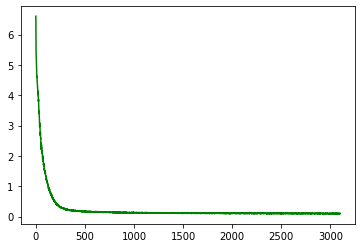

 16%|█▌        | 3200/20001 [04:25<21:48, 12.84it/s]

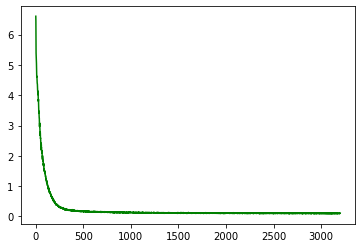

 16%|█▋        | 3300/20001 [04:33<21:37, 12.87it/s]

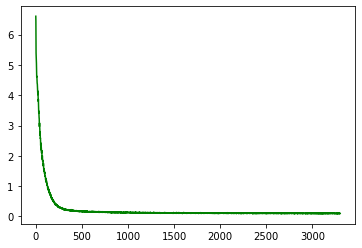

 17%|█▋        | 3400/20001 [04:41<21:33, 12.83it/s]

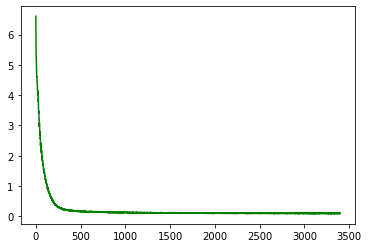

 17%|█▋        | 3500/20001 [04:49<21:28, 12.80it/s]

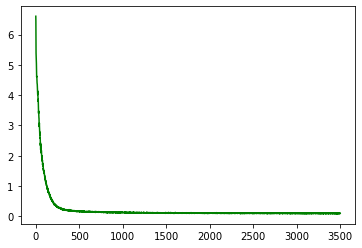

 18%|█▊        | 3600/20001 [04:57<21:32, 12.69it/s]

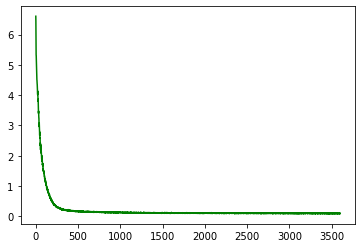

 18%|█▊        | 3700/20001 [05:05<21:04, 12.89it/s]

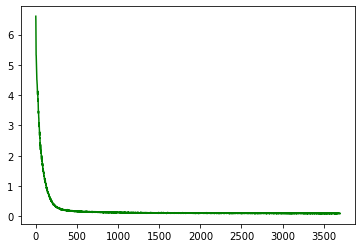

 19%|█▉        | 3800/20001 [05:13<21:13, 12.72it/s]

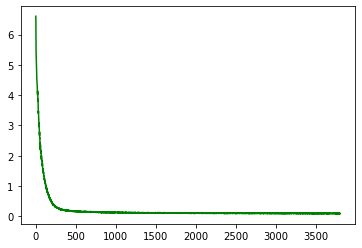

 19%|█▉        | 3900/20001 [05:21<21:47, 12.31it/s]

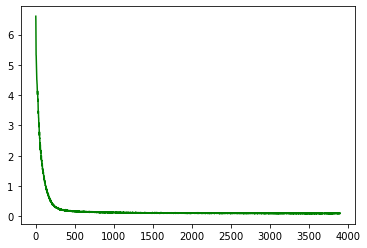

 20%|█▉        | 4000/20001 [05:30<20:51, 12.79it/s]

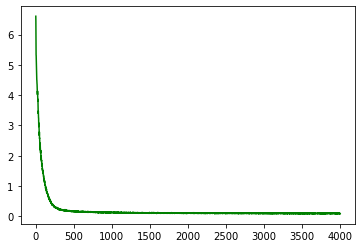

 20%|██        | 4100/20001 [05:38<20:49, 12.73it/s]

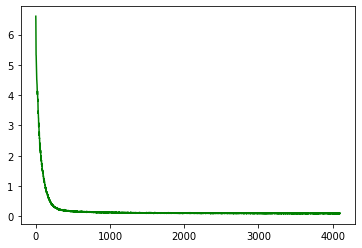

 21%|██        | 4200/20001 [05:46<20:48, 12.66it/s]

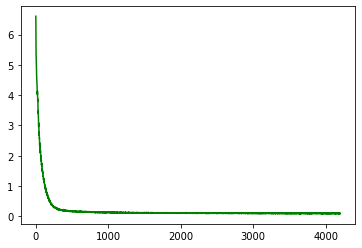

 21%|██▏       | 4300/20001 [05:54<20:24, 12.82it/s]

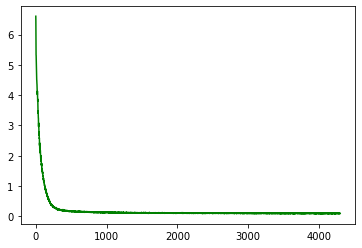

 22%|██▏       | 4400/20001 [06:02<20:47, 12.51it/s]

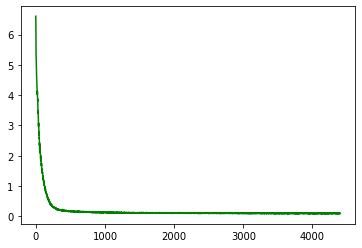

 22%|██▏       | 4500/20001 [06:10<22:20, 11.56it/s]

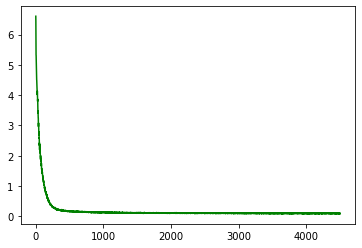

 23%|██▎       | 4600/20001 [06:19<22:10, 11.58it/s]

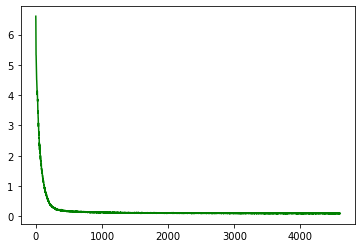

 23%|██▎       | 4700/20001 [06:28<20:01, 12.73it/s]

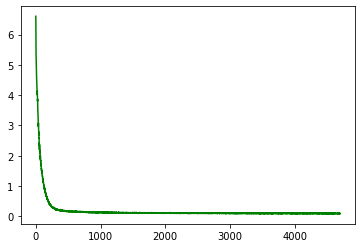

 24%|██▍       | 4800/20001 [06:36<19:47, 12.80it/s]

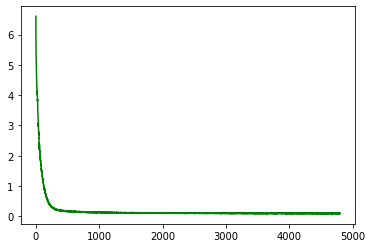

 24%|██▍       | 4900/20001 [06:44<19:39, 12.80it/s]

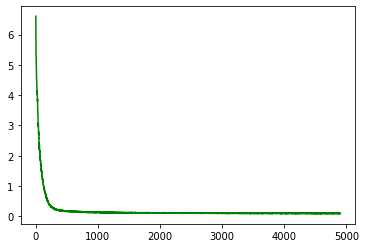

 25%|██▍       | 5000/20001 [06:52<19:26, 12.86it/s]

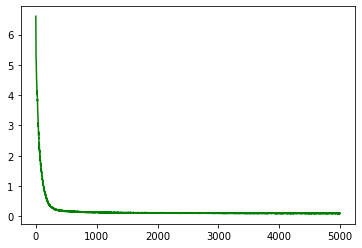

 25%|██▌       | 5100/20001 [07:00<19:25, 12.78it/s]

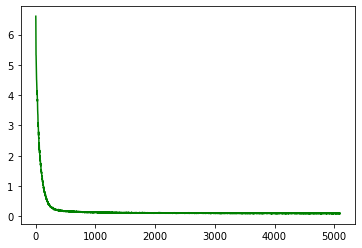

 26%|██▌       | 5200/20001 [07:08<20:04, 12.29it/s]

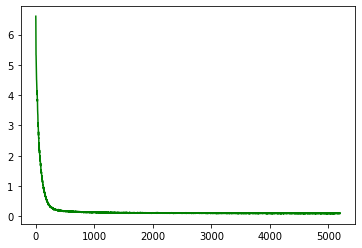

 26%|██▋       | 5300/20001 [07:16<19:18, 12.69it/s]

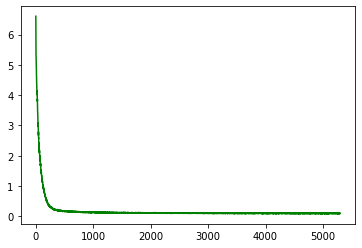

 27%|██▋       | 5400/20001 [07:25<18:57, 12.84it/s]

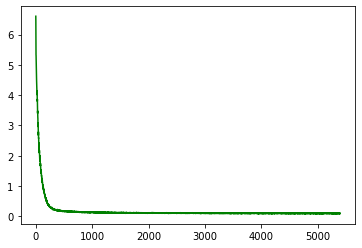

 27%|██▋       | 5500/20001 [07:33<19:04, 12.67it/s]

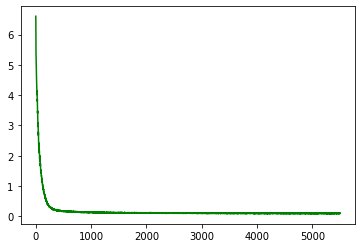

 28%|██▊       | 5600/20001 [07:41<18:51, 12.73it/s]

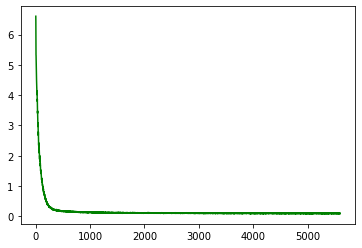

 28%|██▊       | 5700/20001 [07:49<18:44, 12.71it/s]

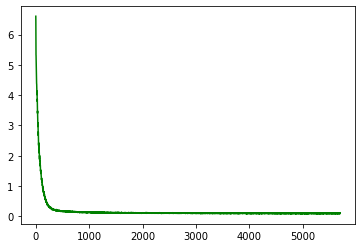

 29%|██▊       | 5734/20001 [07:52<19:34, 12.14it/s]


KeyboardInterrupt: ignored

In [74]:


##################
# Begin training!#
##################

history = []
# plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
plt.title('Loss over time')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for iter in tqdm(range(num_training_iterations)):
  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(tokenized_all_text, batch_size=batch_size, sequence_length=sequence_length)
  loss = train_step(x_batch, y_batch)

#   print("Input shape:      ", x_batch.shape, " # (batch_size, sequence_length)")
#   print("Prediction shape: ", y_batch.shape, "# (batch_size, sequence_length, vocab_size)")

  # Update the progress bar
  history.append(loss.numpy().mean())

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)
    plt.plot(range(iter + 1), history, 'g', label='Training loss')
    plt.show()

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)
# plt.plot(epochs, loss_val, 'b', label='validation loss')    plt.show()
plt.plot(range(101,num_training_iterations), history[101:num_training_iterations], 'g', label='Training loss')


In [ ]:
prompts = ["hi",""]
prompts = [prompt + " startseqtok" for prompt in prompts]
print(prompts)

['hi startseqtok', ' startseqtok']


In [75]:


############## Inference ######################


# batch size None for inference, remove statefulness and allow any size input
model = build_model(vocab_size=len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=None)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

## Prediction of a chat class ###
# prompts should be a list or single string
def classify_next(prompts):

    # convert to list if needed
    prompts = [prompts] if isinstance(prompts, str) else prompts

    # up the dimension if single inference...its hacky i know...
    single_item = False
    if len(prompts) == 1:
       prompts.append("")
       single_item = True

    # add the tokens for starting the response sequence
    prompts = ["promptstartseq " + prompt + " promptendseq responsestartseq " for prompt in prompts]

    # Evaluation step (generating ABC text using the learned RNN model)
    input_eval = vectorize_layer(tf.squeeze(prompts))
    pred = model(input_eval)
    pred = tf.nn.softmax(pred[:, -1, :])
    # output_labels = tf.argmax(pred, axis=1)

    # Note that this is log probs, see here https://www.tensorflow.org/api_docs/python/tf/random/categorical
    output_labels = np.array(vocab)[tf.squeeze(tf.random.categorical(pred, num_samples=1)).numpy()]

    return output_labels if not single_item else output_labels[0]


def gen_response(prompt):
  
  response = ""
  
  maxCount = 100
  count = 0
  while (count < maxCount) and ("responsestartseq" not in response.lower()):
    response = response + f' {classify_next(prompt + " startseqtok " + response)}'
    count = count + 1
  
  response = response.replace("endseqtok", "")

  return response

# def classify_label(prompts):
#     encoded_labels = classify(prompts)
#     labels = ['recycle', 'review', 'action']
#     return list(map(lambda label: labels[label], encoded_labels))

# # calculate accuracy
# pred_labels = classify(condensed_data_tensor)
# accuracy = np.sum(np.equal(
#     list(map(np.argmax, vector_target)), pred_labels))/len(condensed_data_tensor)
# print(f'Accuracy is {accuracy}')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 256)         188928    
                                                                 
 dropout_6 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_3 (LSTM)               (None, None, 1024)        5246976   
                                                                 
 dropout_7 (Dropout)         (None, None, 1024)        0         
                                                                 
 dense_3 (Dense)             (None, None, 738)         756450    
                                                                 
Total params: 6,192,354
Trainable params: 6,192,354
Non-trainable params: 0
_________________________________________________________________


In [78]:
print(gen_response("The pig did a jig."))

ValueError: ignored